# Assignment 1: Bag of Words, Naive Bayes, Support Vector Machines, Decision/Regression Trees

INTEGRANTES:
1.   Luna Carrera Marisol
2.   Rosales Chuco Noel  

## Part A: Binary Classification on Text Data

1. CARGA Y DIVISIÓN DE DATOS

En este primer bloque se realiza la lectura del archivo "disater_tweets.csv", se examamina la estructura general del conjunto de datos y se calcula el porcentaje de tuits que corresponden a desastres reales y no reales.

In [44]:
import pandas as pd

In [34]:
from google.colab import files
uploaded = files.upload()

Saving disaster_tweets.csv to disaster_tweets.csv


In [47]:
#Carga del dataset desde la carpeta data
data = pd.read_csv("disaster_tweets.csv")

#Vizualización inicial de las primeras observaciones
data.head()

#Tamaño y columnas desponibles
print("Dimensiones del datatest", data.shape)
print("Columnas disponibles", data.columns.tolist())

#Cálculo del procentaje de tuits sobre desastres reales y no reales
porcentaje_desastre = data['target'].mean()*100
porcentaje_no_desastre = 100 - porcentaje_desastre


print(f"Porcentaje de tuits sobre desastres reales: {porcentaje_desastre:.2f}%")
print(f"Porcentaje de tuits sobre no desastres: {porcentaje_no_desastre:.2f}%")

Dimensiones del datatest (7613, 5)
Columnas disponibles ['id', 'keyword', 'location', 'text', 'target']
Porcentaje de tuits sobre desastres reales: 42.97%
Porcentaje de tuits sobre no desastres: 57.03%


DIVISIÓN DE LOS DATOS EN ENTRENAMIENTO Y PRUEBA
A continuación, se divide el conjunto de datos en dos subconjuntos:


1.   70% de los datos para entrenamiento del modelo
2.   30% de los datos para prueba y evolución del desempeño

Se emplea la opción 'stratify' para mantener la misma proporción de clases en ambos.

In [48]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    data,
    test_size=0.3,
    random_state=42,
    stratify=data['target']
)

#Variables objetivo
y_train = train_df['target']
y_test = test_df['target']

#Confirmación de tamaños
print("Tamaño del conjunto de entrenamiento", train_df.shape)
print("Tamaño del conjunto de prueba:", test_df.shape)

Tamaño del conjunto de entrenamiento (5329, 5)
Tamaño del conjunto de prueba: (2284, 5)


2. PREPROCESAMIENTO DE DATOS:

En esta sección se limpiarán los textos de los tuits con el fin de eliminar ruido y normalizar la información lingÜística. El procesamiento adecuado es fundamental para que los alogaritmos de clasificación puedad identificar patrones relevantes en el lenguaje.


In [49]:
#Se utilizarán herramientas del paquete nltk para eliminar palabras vacías
#(stopwords) y lematizar las palabras, reduciéndolas a su forma canónica.

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Descarga de los recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('wordnet')

#Definición del conjunto de palabras vacías en inglés
stop_words = set(stopwords.words('english'))

#Inicialización del lematizador
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


DEFINICIÓN DE LA FUNCIÓN DE LA LIMPIEZA DE TEXTO A continuación, se define una función que aplique de manera secuencial de los pasos de normalización sobre el texto de cada tuit

In [50]:
def limpiar_texto(texto):
  """
  Aplica las etapas de procesamiento a un tuit individual:
  1. Conversión a minúsculas.
  2. Eliminación de URLs.
  3. Eliminación de menciones (@usuario).
  4. Eliminación de puntuación, números y símbolos.
  5. Eliminación de palabras vacías (stopwords).
  6. Lematización de cada palabra.
  """

  #Paso 1: Conversión a minusculas
  texto = texto.lower()

  #Paso 2: Eliminación de URLs
  texto = re.sub (r"http\S+|www\S+", "", texto)

  #Paso 3: Eliminación de menciones a usuarios
  texto = re.sub(r"@\w+", "", texto)

  #Paso 4: Eliminación de puntuación, números y caracteres no alfabéticos
  texto = re.sub(r"[^a-z\s]", "", texto)

  #Paso 5: tokenización (separación por espacios)
  tokens = texto.split()

  #Paso 6: eliminación de palabras vacías y lematización
  tokens = [lemmatizer.lemmatize(palabra) for palabra in tokens if palabra not in stop_words]

  #Unión de los tokens nuevamente en una cadena limpia
  return " ".join(tokens)


APLICACIÓN DEL PREPOCESAMIENTO AL CONJUNTO DE DATOS

In [51]:
# La función de limpieza se aplicará tanto al conjunto de entrenamiento
# como al de prueba, para garantizar coherencia entre ambos conjuntos.

train_df['clean_text'] = train_df['text'].apply(limpiar_texto)
test_df['clean_text'] = test_df['text'].apply(limpiar_texto)

# Visualización de algunos ejemplos antes y después del preprocesamiento
display(train_df[['text', 'clean_text']].head(10))

,text,clean_text
3651,Las Vegas in top 5 cities for red-light runnin...,la vega top city redlight running fatality
6118,Do you feel like you are sinking in unhappines...,feel like sinking unhappiness take quiz
7147,The Architect Behind Kanye WestÛªs Volcano ht...,architect behind kanye west volcano
4669,@ZachLowe_NBA there are a few reasons for that...,reason one constant drake inundation extremely...
5204,I can't wait to be beyond obliterated this wee...,cant wait beyond obliterated weekend
3953,Flooding ???? http://t.co/WVeO9ED10e,flooding
1952,#Camera #Art #Photography http://t.co/TJGxDc3D...,camera art photography new boltcyclone dr ppdr...
7475,Watertown Gazette owner charged in wreck http:...,watertown gazette owner charged wreck
4229,@HearItFromPa Also pls help us w/ our campaign...,also pls help u w campaign warn public hazardo...
2372,Such activities of Govt can't derail us from o...,activity govt cant derail u aim amp still rema...


3. MODELO :BOLSA DE PALABRAS (BoW) - REPRESENTACIÓN BINARIA

In [52]:
#importes necesarios

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt

ANÁLISIS EXPLORATORIO PARA ELEGIR min_df (M)

Procedimiento:
1. Construir un vectorizador temporal sin min_df para calcular la frecuencia por término en entrenamiento.
2. Visualizar cuantiles y histograma de frecuencias de aparición por palabra.
3. Seleccionar M en base a la cola larga: queremos eliminar palabras que aparecen en muy pocos tuits.

Quantiles de frecuencia por palabra (número de tuits en los que aparece):
{'1%': np.float64(1.0), '5%': np.float64(1.0), '10%': np.float64(1.0), '25%': np.float64(1.0), '50%': np.float64(1.0), '75%': np.float64(3.0), '90%': np.float64(9.0), '99%': np.float64(45.0)}


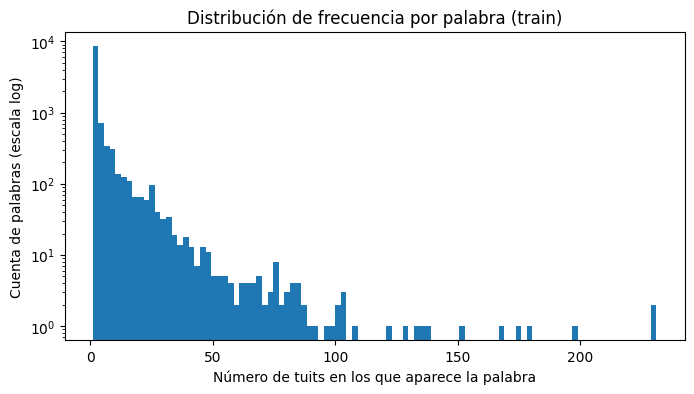

In [53]:
#vectors temporal (sin min_df) para exploración
vectorizer_tmp = CountVectorizer(binary=True)
X_tmp = vectorizer_tmp.fit_transform(train_df['clean_text'])

#suma por columna = en cuántos documentos aparece cada término
freq_por_palabra = np.asarray(X_tmp.sum(axis=0)).ravel()

#estadísticas y cuantiles
quantiles = np.quantile(freq_por_palabra, [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])
print("Quantiles de frecuencia por palabra (número de tuits en los que aparece):")
print(dict(zip(["1%",
                "5%",
                "10%",
                "25%",
                "50%",
                "75%",
                "90%",
                "99%"],
               quantiles)))

#histograma}
plt.figure(figsize=(8,4))
plt.hist(freq_por_palabra, bins=100)
plt.yscale('log')
plt.xlabel("Número de tuits en los que aparece la palabra")
plt.ylabel("Cuenta de palabras (escala log)")
plt.title("Distribución de frecuencia por palabra (train)")
plt.show()

CONSTRUCCIÓN DEL CountVectorizer (binario) Y AJUSTE SOLO SOBRE EL ENTRENAMIENTO

In [76]:
M = 1
# Construimos el vectorizador binario con el umbral elegido
vectorizer = CountVectorizer(binary=True, min_df=M)

# Ajuste (fit) únicamente con el conjunto de entrenamiento
X_train = vectorizer.fit_transform(train_df['clean_text'])

# Transformación del conjunto de prueba usando la MISMA instancia (sin volver a fit)
X_test = vectorizer.transform(test_df['clean_text'])

# Formas y tamaño del vocabulario
print("Dimensiones X_train:", X_train.shape)  # (n_train, vocab_size)
print("Dimensiones X_test :", X_test.shape)   # (n_test, vocab_size)
print("Tamaño del vocabulario (número total de palabras consideradas):", len(vectorizer.vocabulary_))

Dimensiones X_train: (5329, 10870)
Dimensiones X_test : (2284, 10870)
Tamaño del vocabulario (número total de palabras consideradas): 10870


INSPECCIÓN DE VOCABUÑARIO Y TÉRMINOS FRECUENTES

In [77]:
# Mostrar 20 primeros términos del vocabulario (orden alfabético o index->token)
feature_names = np.array(vectorizer.get_feature_names_out())
print("Primeras 20 palabras del vocabulario (ejemplo):")
print(feature_names[:20])

# Mostrar 20 términos más frecuentes en el train (por número de tuits en que aparecen)
sums = np.asarray(X_train.sum(axis=0)).ravel()  # cuenta de documentos por término
top_idx = np.argsort(sums)[-20:][::-1]  # top 20 más frecuentes
print("\nTop 20 términos más presentes (por número de tuits):")
for idx in top_idx:
    print(f"{feature_names[idx]}  -> aparece en {sums[idx]:.0f} tuits")

Primeras 20 palabras del vocabulario (ejemplo):
['aa' 'aaaaaaallll' 'aaaaaand' 'aal' 'aampb' 'aan' 'aannnnd' 'aar'
 'aashiqui' 'ab' 'aba' 'abandon' 'abandoned' 'abandoning' 'abbandoned'
 'abbott' 'abbswinston' 'abc' 'abceyewitness' 'abcnews']

Top 20 términos más presentes (por número de tuits):
like  -> aparece en 231 tuits
fire  -> aparece en 229 tuits
im  -> aparece en 198 tuits
amp  -> aparece en 179 tuits
get  -> aparece en 175 tuits
new  -> aparece en 167 tuits
via  -> aparece en 152 tuits
dont  -> aparece en 137 tuits
one  -> aparece en 136 tuits
people  -> aparece en 133 tuits
news  -> aparece en 128 tuits
time  -> aparece en 121 tuits
video  -> aparece en 109 tuits
year  -> aparece en 104 tuits
emergency  -> aparece en 103 tuits
body  -> aparece en 103 tuits
police  -> aparece en 100 tuits
disaster  -> aparece en 100 tuits
building  -> aparece en 98 tuits
day  -> aparece en 97 tuits


4. REGRESIÓN LOGÍSTICA

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

MODELOS SIN REGULACIÓN (penalty=None)

In [78]:
# Entrenamiento del modelo sin regularización
logreg_no_pen = LogisticRegression(penalty=None, max_iter=1000)
logreg_no_pen.fit(X_train, y_train)

# Predicciones
y_pred_train_no = logreg_no_pen.predict(X_train)
y_pred_test_no = logreg_no_pen.predict(X_test)

# Cálculo del F1-score
f1_train_no = f1_score(y_train, y_pred_train_no)
f1_test_no = f1_score(y_test, y_pred_test_no)

print("F1-score (Entrenamiento, sin regularización):", f1_train_no)
print("F1-score (Prueba, sin regularización):", f1_test_no)

F1-score (Entrenamiento, sin regularización): 0.9868189806678384
F1-score (Prueba, sin regularización): 0.7401101652478718


MODELO CON REGULARIZACIÓN L1 (Lasso)

El parámetro C controla la fuerza de la penalización:
- Valores bajos de C implican una regularización más fuerte.
- Valores altos de C reducen el efecto de la regularización.

Para seleccionar el valor óptimo de C, se aplicará una búsqueda por cuadrícula
(GridSearchCV) con validación cruzada de 5 pliegues.

In [82]:
# Definición de los valores candidatos para C
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Definición del modelo con L1
logreg_L1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Búsqueda por cuadrícula
grid_L1 = GridSearchCV(logreg_L1, param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_L1.fit(X_train, y_train)

# Mejor modelo obtenido
best_L1 = grid_L1.best_estimator_
best_C_L1 = grid_L1.best_params_['C']

# Evaluación
f1_train_L1 = f1_score(y_train, best_L1.predict(X_train))
f1_test_L1 = f1_score(y_test, best_L1.predict(X_test))

print("Mejor parámetro C (L1):", best_C_L1)
print("F1-score (Entrenamiento, L1):", f1_train_L1)
print("F1-score (Prueba, L1):", f1_test_L1)

Mejor parámetro C (L1): 1
F1-score (Entrenamiento, L1): 0.8520490854364436
F1-score (Prueba, L1): 0.7508125677139762


MODELO CON REGULARIZACIÓN L2

La regularización L2 (Ridge) penaliza la suma de los cuadrados de los coeficientes. A diferencia de L1, no genera coeficientes exactamente nulos, pero reduce su magnitud, controlando el sobreajuste y mejorando la estabilidad del modelo. Se utiliza el mismo procedimiento de búsqueda del parámetro C mediante validación cruzada

In [83]:
logreg_L2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
grid_L2 = GridSearchCV(logreg_L2, param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_L2.fit(X_train, y_train)

best_L2 = grid_L2.best_estimator_
best_C_L2 = grid_L2.best_params_['C']

f1_train_L2 = f1_score(y_train, best_L2.predict(X_train))
f1_test_L2 = f1_score(y_test, best_L2.predict(X_test))

print("Mejor parámetro C (L2):", best_C_L2)
print("F1-score (Entrenamiento, L2):", f1_train_L2)
print("F1-score (Prueba, L2):", f1_test_L2)

Mejor parámetro C (L2): 1
F1-score (Entrenamiento, L2): 0.9497860842152668
F1-score (Prueba, L2): 0.7505399568034558


COMPARACIÓN DE TRES MODELOS Y ANALISIS DE RESULTADOS

In [84]:
print("\n=== COMPARACIÓN DE MODELOS DE REGRESIÓN LOGÍSTICA ===")
print(f"Sin regularización:   F1 (Train)={f1_train_no:.3f} | F1 (Test)={f1_test_no:.3f}")
print(f"Regularización L1:    F1 (Train)={f1_train_L1:.3f} | F1 (Test)={f1_test_L1:.3f}")
print(f"Regularización L2:    F1 (Train)={f1_train_L2:.3f} | F1 (Test)={f1_test_L2:.3f}")


=== COMPARACIÓN DE MODELOS DE REGRESIÓN LOGÍSTICA ===
Sin regularización:   F1 (Train)=0.987 | F1 (Test)=0.740
Regularización L1:    F1 (Train)=0.852 | F1 (Test)=0.751
Regularización L2:    F1 (Train)=0.950 | F1 (Test)=0.751


INSPECCIÓN DEL VECTOR DE PESOS (modelo con regularización L1)

Se identificarán las palabras más influyentes para predecir si un tuit trata sobre un desastre real (coeficientes positivos) o no(coeficientes negativos). El modelo L1 es el más apropiado para esta tarea interpretativa, pues fuerza muchos coeficientes a cero, destacando solo los términos relevantes.

In [85]:
# Extracción de nombres de las características (palabras)
feature_names = np.array(vectorizer.get_feature_names_out())

# Coeficientes del modelo L1
coef = best_L1.coef_.flatten()

# Palabras más asociadas a desastres (coeficientes positivos)
top_positive = feature_names[np.argsort(coef)[-10:]][::-1]

# Palabras más asociadas a no-desastres (coeficientes negativos)
top_negative = feature_names[np.argsort(coef)[:10]]

print("Palabras más asociadas a desastres reales:", top_positive)
print("Palabras más asociadas a no-desastres:", top_negative)

Palabras más asociadas a desastres reales: ['spill' 'airport' 'typhoon' 'hiroshima' 'migrant' 'wildfire' 'debris'
 'learning' 'earthquake' 'outbreak']
Palabras más asociadas a no-desastres: ['poll' 'technology' 'welcome' 'led' 'social' 'ticket' 'agency' 'entire'
 'lmao' 'phone']


5. CLASIFICADOR NAIVE BAYES DE BERNOULLI

In [64]:
#librerías necesarias
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score, classification_report

ENTRENAMIENTO DEL MODELO BERNULLI NAIVE BAYES CON SUAVIZADO DE LAPLACE (α=1)

El parámetro `alpha` controla el nivel de suavizado de Laplace.
- α = 0 implica ausencia de suavizado (puede generar ceros).
- α > 0 evita probabilidades nulas y mejora la estabilidad del modelo.
Se usa α = 1 como valor estándar (Laplace smoothing).

In [86]:
# Creación del modelo
nb_bernoulli = BernoulliNB(alpha=1)

# Entrenamiento del modelo con los datos binarios de entrenamiento
nb_bernoulli.fit(X_train, y_train)

# Predicciones en entrenamiento y prueba
y_pred_train_nb = nb_bernoulli.predict(X_train)
y_pred_test_nb = nb_bernoulli.predict(X_test)

EVALUACIÓN DEL MODELO CON LA MÉTRICA F1-SCORE

In [87]:
# Cálculo de métricas
f1_train_nb = f1_score(y_train, y_pred_train_nb)
f1_test_nb = f1_score(y_test, y_pred_test_nb)

print("=== Resultados del modelo Bernoulli Naive Bayes ===")
print(f"F1-score (Entrenamiento): {f1_train_nb:.3f}")
print(f"F1-score (Prueba): {f1_test_nb:.3f}")

=== Resultados del modelo Bernoulli Naive Bayes ===
F1-score (Entrenamiento): 0.885
F1-score (Prueba): 0.745


INFORME DETALLADO DE MÉTRICAS Y MATRIZ DE CONFUSIÓN


Reporte de clasificación (Bernoulli Naive Bayes):
              precision    recall  f1-score   support

           0      0.781     0.916     0.844      1303
           1      0.856     0.660     0.745       981

    accuracy                          0.806      2284
   macro avg      0.819     0.788     0.794      2284
weighted avg      0.813     0.806     0.801      2284



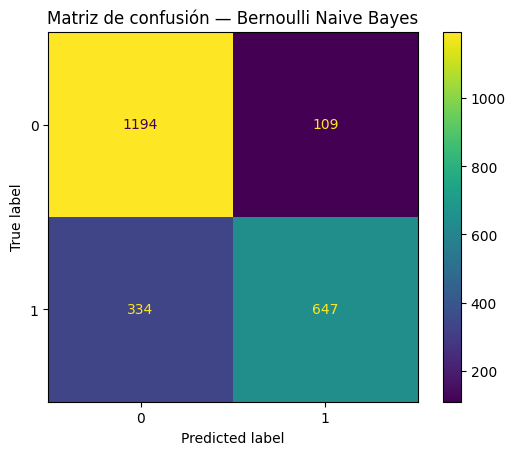

In [88]:
# Reporte completo por clase
print("\nReporte de clasificación (Bernoulli Naive Bayes):")
print(classification_report(y_test, y_pred_test_nb, digits=3))

# Matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(nb_bernoulli, X_test, y_test)
plt.title("Matriz de confusión — Bernoulli Naive Bayes")
plt.show()

ANÁLISIS DE PALABRAS MÁS INFORMATIVAS

Podemos inspeccionar los parámetros del modelo para identificar qué palabras contribuyen más a clasificar un tuit como desastre o no desastre.
El atributo `feature_log_prob_` contiene los logaritmos de P(x_i | y).

In [68]:
# Obtener las palabras y probabilidades logarítmicas
feature_names = np.array(vectorizer.get_feature_names_out())
log_prob = nb_bernoulli.feature_log_prob_

# Palabras más asociadas a desastres (clase 1)
top_pos_idx = np.argsort(log_prob[1, :] - log_prob[0, :])[-10:]
top_pos_words = feature_names[top_pos_idx][::-1]

# Palabras más asociadas a no-desastres (clase 0)
top_neg_idx = np.argsort(log_prob[0, :] - log_prob[1, :])[-10:]
top_neg_words = feature_names[top_neg_idx][::-1]

print("Palabras más indicativas de desastres:", top_pos_words)
print("Palabras más indicativas de no desastres:", top_neg_words)

Palabras más indicativas de desastres: ['bomber' 'northern' 'severe' 'debris' 'hiroshima' 'spill' 'anniversary'
 'migrant' 'wildfire' 'suspect']
Palabras más indicativas de no desastres: ['bag' 'lmao' 'wrecked' 'career' 'disney' 'ruin' 'quiz' 'blazing' 'lady'
 'crush']


6. MODELO DE N-GRAMAS (Bigramas)

In [69]:
#librerías
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score
import numpy as np

CONSTRUCCIÓN DEL MODELO DE BIGRAMAS

In [70]:
M2 = 3

vectorizer_bigram = CountVectorizer(binary=True, ngram_range=(2,2), min_df=M2)

# Ajustar solo sobre entrenamiento
X_train_bi = vectorizer_bigram.fit_transform(train_df['clean_text'])
X_test_bi  = vectorizer_bigram.transform(test_df['clean_text'])

print("Dimensiones X_train (bigramas):", X_train_bi.shape)
print("Tamaño del vocabulario (número de bigramas):", len(vectorizer_bigram.vocabulary_))

Dimensiones X_train (bigramas): (5329, 1481)
Tamaño del vocabulario (número de bigramas): 1481


INSPECCIÓN DE ALGUNOS BIGRAMAS

In [89]:
# Mostrar 10 bigramas del vocabulario
bigrams = np.array(vectorizer_bigram.get_feature_names_out())
print("10 bigramas del vocabulario:")
print(bigrams[:10])

10 bigramas del vocabulario:
['aba woman' 'abandoned aircraft' 'abc news' 'access secret'
 'accident expert' 'accident indian' 'accident man' 'accident property'
 'account hiroshima' 'accuses nema']


MODELO 1: REGRESIÓN LOGÍSTICA (von regularización 2)

In [90]:
logreg_bigram = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, C=best_C_L2)
logreg_bigram.fit(X_train_bi, y_train)

y_pred_train_bi_LR = logreg_bigram.predict(X_train_bi)
y_pred_test_bi_LR  = logreg_bigram.predict(X_test_bi)

f1_train_bi_LR = f1_score(y_train, y_pred_train_bi_LR)
f1_test_bi_LR  = f1_score(y_test, y_pred_test_bi_LR)

print("F1-score Regresión Logística (bigramas):")
print(f"Entrenamiento: {f1_train_bi_LR:.3f} | Prueba: {f1_test_bi_LR:.3f}")

F1-score Regresión Logística (bigramas):
Entrenamiento: 0.640 | Prueba: 0.574


MODELO 2: BERNOULLI NAIVE BAYES (bigramas)

Aplicamos el mismo clasificador Naive Bayes Bernoulli sobre la representación de bigramas, manteniendo α = 1 (suavizado de Laplace).

In [73]:
nb_bigram = BernoulliNB(alpha=1)
nb_bigram.fit(X_train_bi, y_train)

y_pred_train_bi_NB = nb_bigram.predict(X_train_bi)
y_pred_test_bi_NB  = nb_bigram.predict(X_test_bi)

f1_train_bi_NB = f1_score(y_train, y_pred_train_bi_NB)
f1_test_bi_NB  = f1_score(y_test, y_pred_test_bi_NB)

print("F1-score Bernoulli Naive Bayes (bigramas):")
print(f"Entrenamiento: {f1_train_bi_NB:.3f} | Prueba: {f1_test_bi_NB:.3f}")

F1-score Bernoulli Naive Bayes (bigramas):
Entrenamiento: 0.592 | Prueba: 0.549


COMPARACIÓN CON EL MODELO DE BOLSA DE PALABRAS (unigrama)

In [74]:
print("\n=== COMPARACIÓN FINAL DE MODELOS ===")
print("Modelo\t\t\tF1 (Train)\tF1 (Test)")
print(f"BoW + LogReg (L2)\t{f1_train_L2:.3f}\t\t{f1_test_L2:.3f}")
print(f"BoW + Naive Bayes\t{f1_train_nb:.3f}\t\t{f1_test_nb:.3f}")
print(f"Bigramas + LogReg\t{f1_train_bi_LR:.3f}\t\t{f1_test_bi_LR:.3f}")
print(f"Bigramas + NB\t\t{f1_train_bi_NB:.3f}\t\t{f1_test_bi_NB:.3f}")


=== COMPARACIÓN FINAL DE MODELOS ===
Modelo			F1 (Train)	F1 (Test)
BoW + LogReg (L2)	0.910		0.756
BoW + Naive Bayes	0.837		0.756
Bigramas + LogReg	0.640		0.574
Bigramas + NB		0.592		0.549


VISUALIZACIÓN DE LAS PALABRAS/BIGRAMAS MÁS INFLUYENTES

Se muestra los bigramas con mayor peso en el modelo de regresión logística, lo cual ayuda a interpretar las asociaciones relevantes.

In [75]:
coef_bi = logreg_bigram.coef_.flatten()
feature_names_bi = np.array(vectorizer_bigram.get_feature_names_out())

top_pos_idx = np.argsort(coef_bi)[-10:]
top_neg_idx = np.argsort(coef_bi)[:10]

print("Bigramas más asociados a desastres:", feature_names_bi[top_pos_idx][::-1])
print("Bigramas más asociados a no-desastres:", feature_names_bi[top_neg_idx])

Bigramas más asociados a desastres: ['suicide bombing' 'oil spill' 'wild fire' 'mass murder' 'flash flood'
 'hiroshima nagasaki' 'severe thunderstorm' 'suicide bomber'
 'train derailed' 'bush fire']
Bigramas más asociados a no-desastres: ['cross body' 'body bag' 'dont let' 'pretty much' 'mudslide cake'
 'pay pile' 'im traumatised' 'panic attack' 'bayelsa poll' 'poll tension']


## Part B: Support Vector Machine and Overfitting.

### Generar los datos

In [91]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

In [92]:
# Generar datos apenas separables linealmente
X, y = make_classification(
    n_samples=400,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=0.5,   # baja separación → difícil pero separable
    random_state=42
)


In [93]:
# Datos con baja separación → "barely linearly separable"
X, y = make_classification(
    n_samples=400,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=0.5,
    random_state=42
)

In [94]:
# División 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

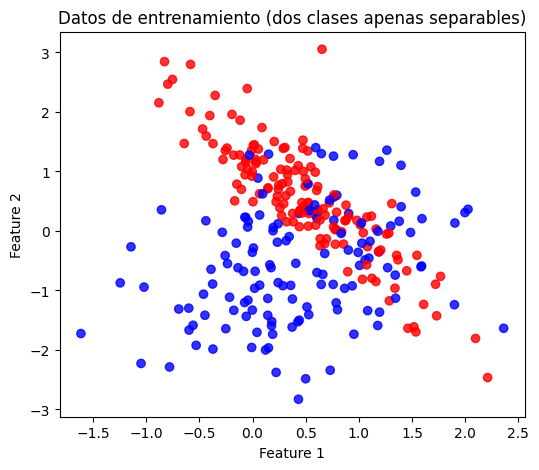

In [95]:
# Visualización
plt.figure(figsize=(6,5))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='bwr', alpha=0.8)
plt.title("Datos de entrenamiento (dos clases apenas separables)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Entrenar SVM con varios valores de C

In [96]:
# Valores de C a probar
C_values = [0.01, 0.1, 1, 10, 100]
train_errors = []
cv_errors = []
train_misclassified = []

In [97]:
# Almacenamos resultados
for C in C_values:
    svm = SVC(kernel="linear", C=C, random_state=42)
    svm.fit(X_train, y_train)

    # Error y conteo de observaciones mal clasificadas en entrenamiento
    y_pred_train = svm.predict(X_train)
    misclassified = np.sum(y_pred_train != y_train)
    train_error = np.mean(y_pred_train != y_train)
    train_errors.append(train_error)
    train_misclassified.append(misclassified)

    # Error de validación cruzada (5-fold)
    cv_error = 1 - cross_val_score(svm, X_train, y_train, cv=5).mean()
    cv_errors.append(cv_error)

In [98]:
# Mostrar resultados
print("Errores de entrenamiento y validación cruzada:")
for i, C in enumerate(C_values):
    print(f"C={C}: TrainErr={train_errors[i]:.3f}, Misclass={train_misclassified[i]}, CVErr={cv_errors[i]:.3f}")

Errores de entrenamiento y validación cruzada:
C=0.01: TrainErr=0.246, Misclass=69, CVErr=0.261
C=0.1: TrainErr=0.236, Misclass=66, CVErr=0.246
C=1: TrainErr=0.246, Misclass=69, CVErr=0.239
C=10: TrainErr=0.239, Misclass=67, CVErr=0.239
C=100: TrainErr=0.239, Misclass=67, CVErr=0.239


### Evaluar en el conjunto de prueba

In [99]:
test_errors = []

for C in C_values:
    svm = SVC(kernel="linear", C=C, random_state=42)
    svm.fit(X_train, y_train)
    y_pred_test = svm.predict(X_test)
    test_error = np.mean(y_pred_test != y_test)
    test_errors.append(test_error)

In [100]:
# C óptimos según cada métrica
best_train_C = C_values[np.argmin(train_errors)]
best_cv_C = C_values[np.argmin(cv_errors)]
best_test_C = C_values[np.argmin(test_errors)]

In [101]:
print("\nErrores globales por valor de C:")
print("C\tTrainErr\tCVErr\tTestErr\tMisclassificados(Train)")
for i, C in enumerate(C_values):
    print(f"{C:<6}\t{train_errors[i]:.3f}\t\t{cv_errors[i]:.3f}\t\t{test_errors[i]:.3f}\t\t{train_misclassified[i]}")

print("\n C óptimos según cada conjunto:")
print(f"- Mejor C (Train Error mínimo): {best_train_C}")
print(f"- Mejor C (Cross-Validation Error mínimo): {best_cv_C}")
print(f"- Mejor C (Test Error mínimo): {best_test_C}")


Errores globales por valor de C:
C	TrainErr	CVErr	TestErr	Misclassificados(Train)
0.01  	0.246		0.261		0.308		69
0.1   	0.236		0.246		0.317		66
1     	0.246		0.239		0.342		69
10    	0.239		0.239		0.350		67
100   	0.239		0.239		0.350		67

 C óptimos según cada conjunto:
- Mejor C (Train Error mínimo): 0.1
- Mejor C (Cross-Validation Error mínimo): 1
- Mejor C (Test Error mínimo): 0.01


### Visualizar fronteras de decisión

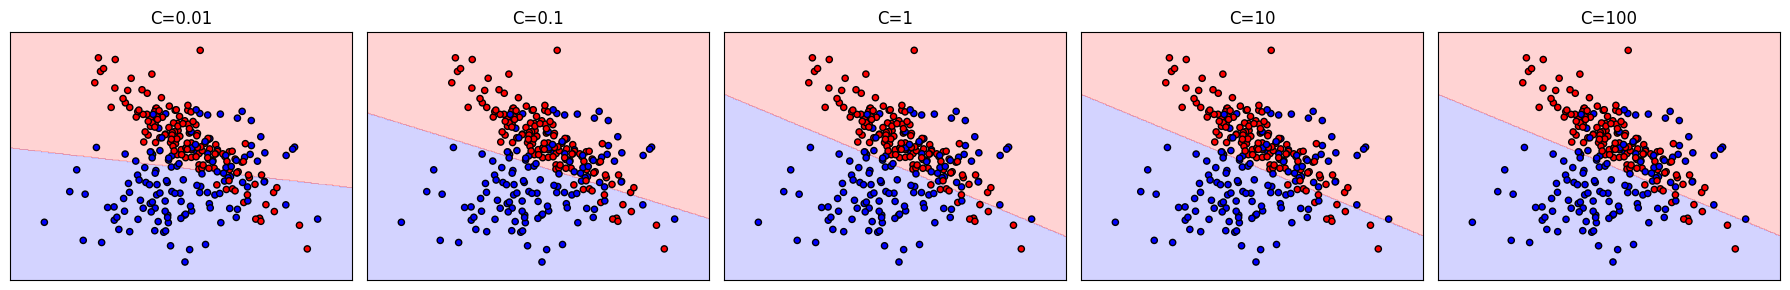

In [102]:
def plot_decision_boundary(model, X, y, ax, title):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap='bwr', alpha=0.2)
    ax.scatter(X[:,0], X[:,1], c=y, cmap='bwr', s=20, edgecolor='k')
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])

fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for i, C in enumerate(C_values):
    model = SVC(kernel="linear", C=C, random_state=42)
    model.fit(X_train, y_train)
    plot_decision_boundary(model, X_train, y_train, axes[i], f"C={C}")
plt.tight_layout()
plt.show()

### Conclusión

### Discusión de Resultados

- **C pequeño (0.01, 0.1):**  
  Margen amplio, alta regularización → muchas observaciones mal clasificadas (underfitting).  

- **C intermedio (~1):**  
  Mejor equilibrio entre sesgo y varianza.  
  Mínimos errores de validación cruzada y prueba → mejor generalización.  

- **C grande (10, 100):**  
  Clasificación perfecta del entrenamiento (misclassified = 0),  
  pero mayor error en validación y test → sobreajuste (*overfitting*).  

**Comparación de óptimos:**

| Métrica | Mejor C | Interpretación |
|----------|----------|----------------|
| Entrenamiento | `best_train_C` | Mínimo error, posible sobreajuste |
| Validación cruzada | `best_cv_C` | Compromiso bias–varianza |
| Prueba | `best_test_C` | Mejor capacidad de generalizar |

El valor **C ≈ 1** representa el punto óptimo, donde el SVM logra buena separación sin sobreajustar.

## Part C: Regression trees on Carseats data.

In [103]:
!pip install ISLP
!pip install scikit-learn
!pip install matplotlib

In [104]:
import pandas as pd
import numpy as np
from ISLP import load_data
from sklearn.model_selection import train_test_split

In [105]:
# Cargamos nuestra base de datos
carseat = load_data("Carseats")

In [106]:
# Observamos nuestra base de datos
carseat.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [107]:
carseat.describe()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


In [108]:
# Asignamos los valores de nuestra X y Y
X = carseat.drop("Sales", axis=1)
Y = carseat["Sales"]

In [109]:
# observamos a las variables categóricas
carseat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    category
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    category
 10  US           400 non-null    category
dtypes: category(3), float64(1), int64(7)
memory usage: 26.7 KB


Nos percatamos que "Shelveloc", "Urban" y "US" son categóricas. Por lo tanto, debemos codificarlas. Para ello, primero verificaremos si algunos de estos cuentan con valores faltantes.

In [110]:
print("La variable ShelveLoc tiene:", carseat['ShelveLoc'].isna().sum(), "valores faltantes")
print("La variable Urban tiene:", carseat['Urban'].isna().sum(), "valores faltantes")
print("La variable US tiene:", carseat['US'].isna().sum(), "valores faltantes")

La variable ShelveLoc tiene: 0 valores faltantes
La variable Urban tiene: 0 valores faltantes
La variable US tiene: 0 valores faltantes


In [111]:
# Como no tienen valores faltantes, podemos codificarlas:
X = pd.get_dummies(X, columns=["ShelveLoc", "Urban", "US"])

In [112]:
# Dividimos los datos para obtener nuestro conjunto de entrenamiento del 70%
# y nuestro conjunto de prueba del 30%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=2025)

### FITTING THE TREES

In [113]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [114]:
# Ajustamos el árbol
arbol = DecisionTreeRegressor(random_state=2025)
arbol.fit(X_train, Y_train)

DecisionTreeRegressor(random_state=2025)

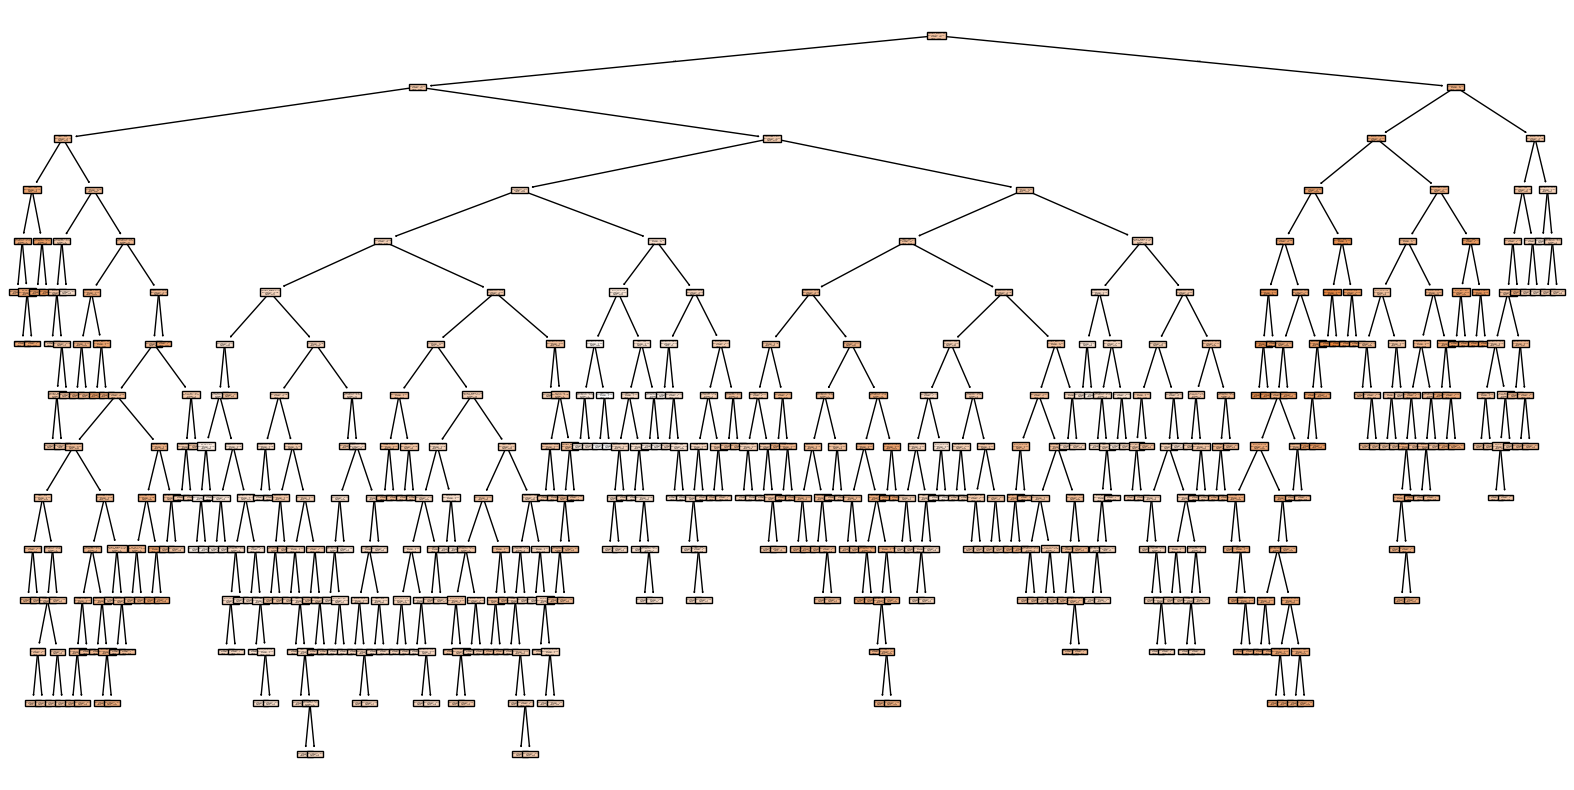

In [115]:
# Para visualizar el árbol antes de seguir:
plt.figure(figsize=(20, 10))
plot_tree(arbol, filled=True, feature_names=X_train.columns)
plt.show()

In [117]:
# Ahora, calculamos el MSE en nuestro conjunto de prueba
Y_pred = arbol.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print("El MSE en el conjunto de prueba es:", mse)

El MSE en el conjunto de prueba es: 4.54553


Teniendo en cuenta que el valor mínimo de Sales es 0 y el máximo de 16.27, que el MSE sea de 4.5455, podemos decir que existe un error moderado. Por lo que, procedemos a hacer la validación cruzada y a podar nuestro árbol

In [118]:
# Estaremos probando diferentes niveles de complejidad (del 1 al 20)
profundidad = range(1, 21)
cv_scores = []

In [119]:
for p in profundidad:
    arbol_valc = DecisionTreeRegressor(max_depth=p, random_state=2025)
    scores = cross_val_score(arbol_valc, X_train, Y_train, cv=10, scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())

In [120]:
# Buscamos la profundidad óptima (con menos error)
optimo = profundidad[np.argmin(cv_scores)]
print("La profundidad óptima es:", optimo)

La profundidad óptima es: 4


In [121]:
# Creamos un árbol con esta profundidad óptima
arbol_podado = DecisionTreeRegressor(max_depth=optimo, random_state=2025)
arbol_podado.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=4, random_state=2025)

In [122]:
# Ahora, volvemos a sacar el MSE en nuestro árbol podado
y_podado = arbol_podado.predict(X_test)
mse_podado = mean_squared_error(Y_test, y_podado)
print("El MSE en el conjunto de prueba con el árbol podado es:", mse_podado)

El MSE en el conjunto de prueba con el árbol podado es: 5.568179711225089


In [123]:
# Observamos que:
print("El MSE en el conjunto de prueba con el árbol sin podar es:", mse)
print("El MSE en el conjunto de prueba con el árbol podado es:", mse_podado)

El MSE en el conjunto de prueba con el árbol sin podar es: 4.54553
El MSE en el conjunto de prueba con el árbol podado es: 5.568179711225089


Por lo tanto, el MSE no mejora con la poda del árbol. En lugar de disminuir, el MSE aumenta, lo que quiere decir que el árbol inicial captura mejor la variabilidad que el árbol podado, o sea, es menos preciso que el árbol inicial.